In [1]:
# import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web


#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Total Assets": "WALCL",
               # Liabilities
               "Total Liabilities" : "WLTLECL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Currency in Circulation": "WCURCIR",
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4.5
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [2]:
rate_keys = ["Unemployment Rate",
               "Effective Federal Funds Rate (%)",
               "Federal Funds Target Rate (Pre-crisis)",
               "Federal Funds Upper Target",
               "Federal Funds Lower Target",
               "Interest on Reserves (%)",
                "5 Year Forward Rate"]
diffs = ["Diff", "Diff-in-Diff"]

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days

if "data_gathered" not in locals():
    data = gather_data(data_codes, start, 
          end = end, freq = freq)
    # transform bil to mil
    data["Currency in Circulation"] = data["Currency in Circulation"].mul(1000)
    data.fillna(0, inplace=True)
    log_diff_data = np.log(data).diff(year)
    log_diff_data[rate_keys] = data[rate_keys]
    data = log_diff_data
    
    data_gathered = True
data

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,Total Assets,Total Liabilities,Unemployment Rate,CPI,Core PCE,Currency in Circulation,Effective Federal Funds Rate (%),Federal Funds Target Rate (Pre-crisis),Federal Funds Upper Target,Federal Funds Lower Target,Interest on Reserves (%),VIX,5 Year Forward Rate
DATE,,,,,,,,,,,,,
2002-12-31,NaN,NaN,6.0,NaN,NaN,NaN,1.238387,1.25,0.000000,0.000000,0.0,NaN,0.000000
2003-01-31,NaN,NaN,5.8,NaN,NaN,NaN,1.235161,1.25,0.000000,0.000000,0.0,NaN,2.110476
2003-02-28,NaN,NaN,5.9,NaN,NaN,NaN,1.262143,1.25,0.000000,0.000000,0.0,NaN,2.171053
2003-03-31,NaN,NaN,5.9,NaN,NaN,NaN,1.252903,1.25,0.000000,0.000000,0.0,NaN,2.030476
2003-04-30,NaN,NaN,6.0,NaN,NaN,NaN,1.258000,1.25,0.000000,0.000000,0.0,NaN,1.980952
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,0.170867,0.171542,3.8,0.076146,0.051630,0.060906,0.080000,0.00,0.250000,0.000000,0.0,0.106788,2.045263
2022-03-31,0.155412,0.155942,3.6,0.082111,0.050719,0.065136,0.200968,0.00,0.370968,0.120968,0.0,0.210794,2.282174
2022-04-30,0.140563,0.141009,3.6,0.079034,0.047961,0.051999,0.330000,0.00,0.500000,0.250000,0.0,0.336096,2.452500


In [3]:
data["Currency in Circulation / Total Assets"] = data["Currency in Circulation"].div(data["Total Assets"].mul(1000))
data["Inflation Loss"]= data["Core PCE"].sub(inflation_target)
data["Unemployment Loss"]= data["Unemployment Rate"].sub(unemployment_target)
data["Inflation Loss Sq"]= data["Core PCE"].sub(inflation_target).pow(2)
data["Inflation Loss Sq"][data["Inflation Loss"] < 0] = data["Inflation Loss Sq"].mul(-1)
data["Unemployment Loss Sq"]= data["Unemployment Rate"].sub(unemployment_target).pow(2)
data["Unemployment Loss Sq"][data["Unemployment Loss"] < 0] = data["Unemployment Loss Sq"].mul(-1)
data["Loss Function"] = data["Inflation Loss Sq"].sub(data["Unemployment Loss Sq"])
data={"data":data,
     "Diff": data.diff(12),
     "Diff-in-Diff": data.diff(12),
     }

for key, val in data.items():
    data[key]["Date"] = val.index.astype(str)

## If data is already downloaded, you can just load it from parquet. If you need to restart kernel, consider commenting out previous two cells

In [4]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# data.to_parquet("FedDAGData.parquet.gzip", compression = "gzip",
#                     engine = "pyarrow")
# data.to_csv("FedDAGData.csv")

In [5]:
# import pandas as pd
# data = pd.read_parquet("FedDAGData.parquet.gzip")

In [6]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import copy
import pingouin
from scipy.stats import pearsonr
from datlib.ts_tests import *
from statsmodels.tsa.adfvalues import *
import warnings
warnings.simplefilter("ignore")
import statsmodels

$FFR$ 1.0
$C$ 1.0
$A$ 0.9988709445681236
$LF$ 1.0
$U_{Loss}$ 1.0
$\pi_{Loss}$ 1.0
$FFR$ 1.0
$C$ 0.0
$A$ 0.0
$LF$ 1.0
$U_{Loss}$ 1.0
$\pi_{Loss}$ 0.0
$FFR$ 1.0
$C$ 0.0
$A$ 0.0
$LF$ 1.0
$U_{Loss}$ 1.0
$\pi_{Loss}$ 0.0


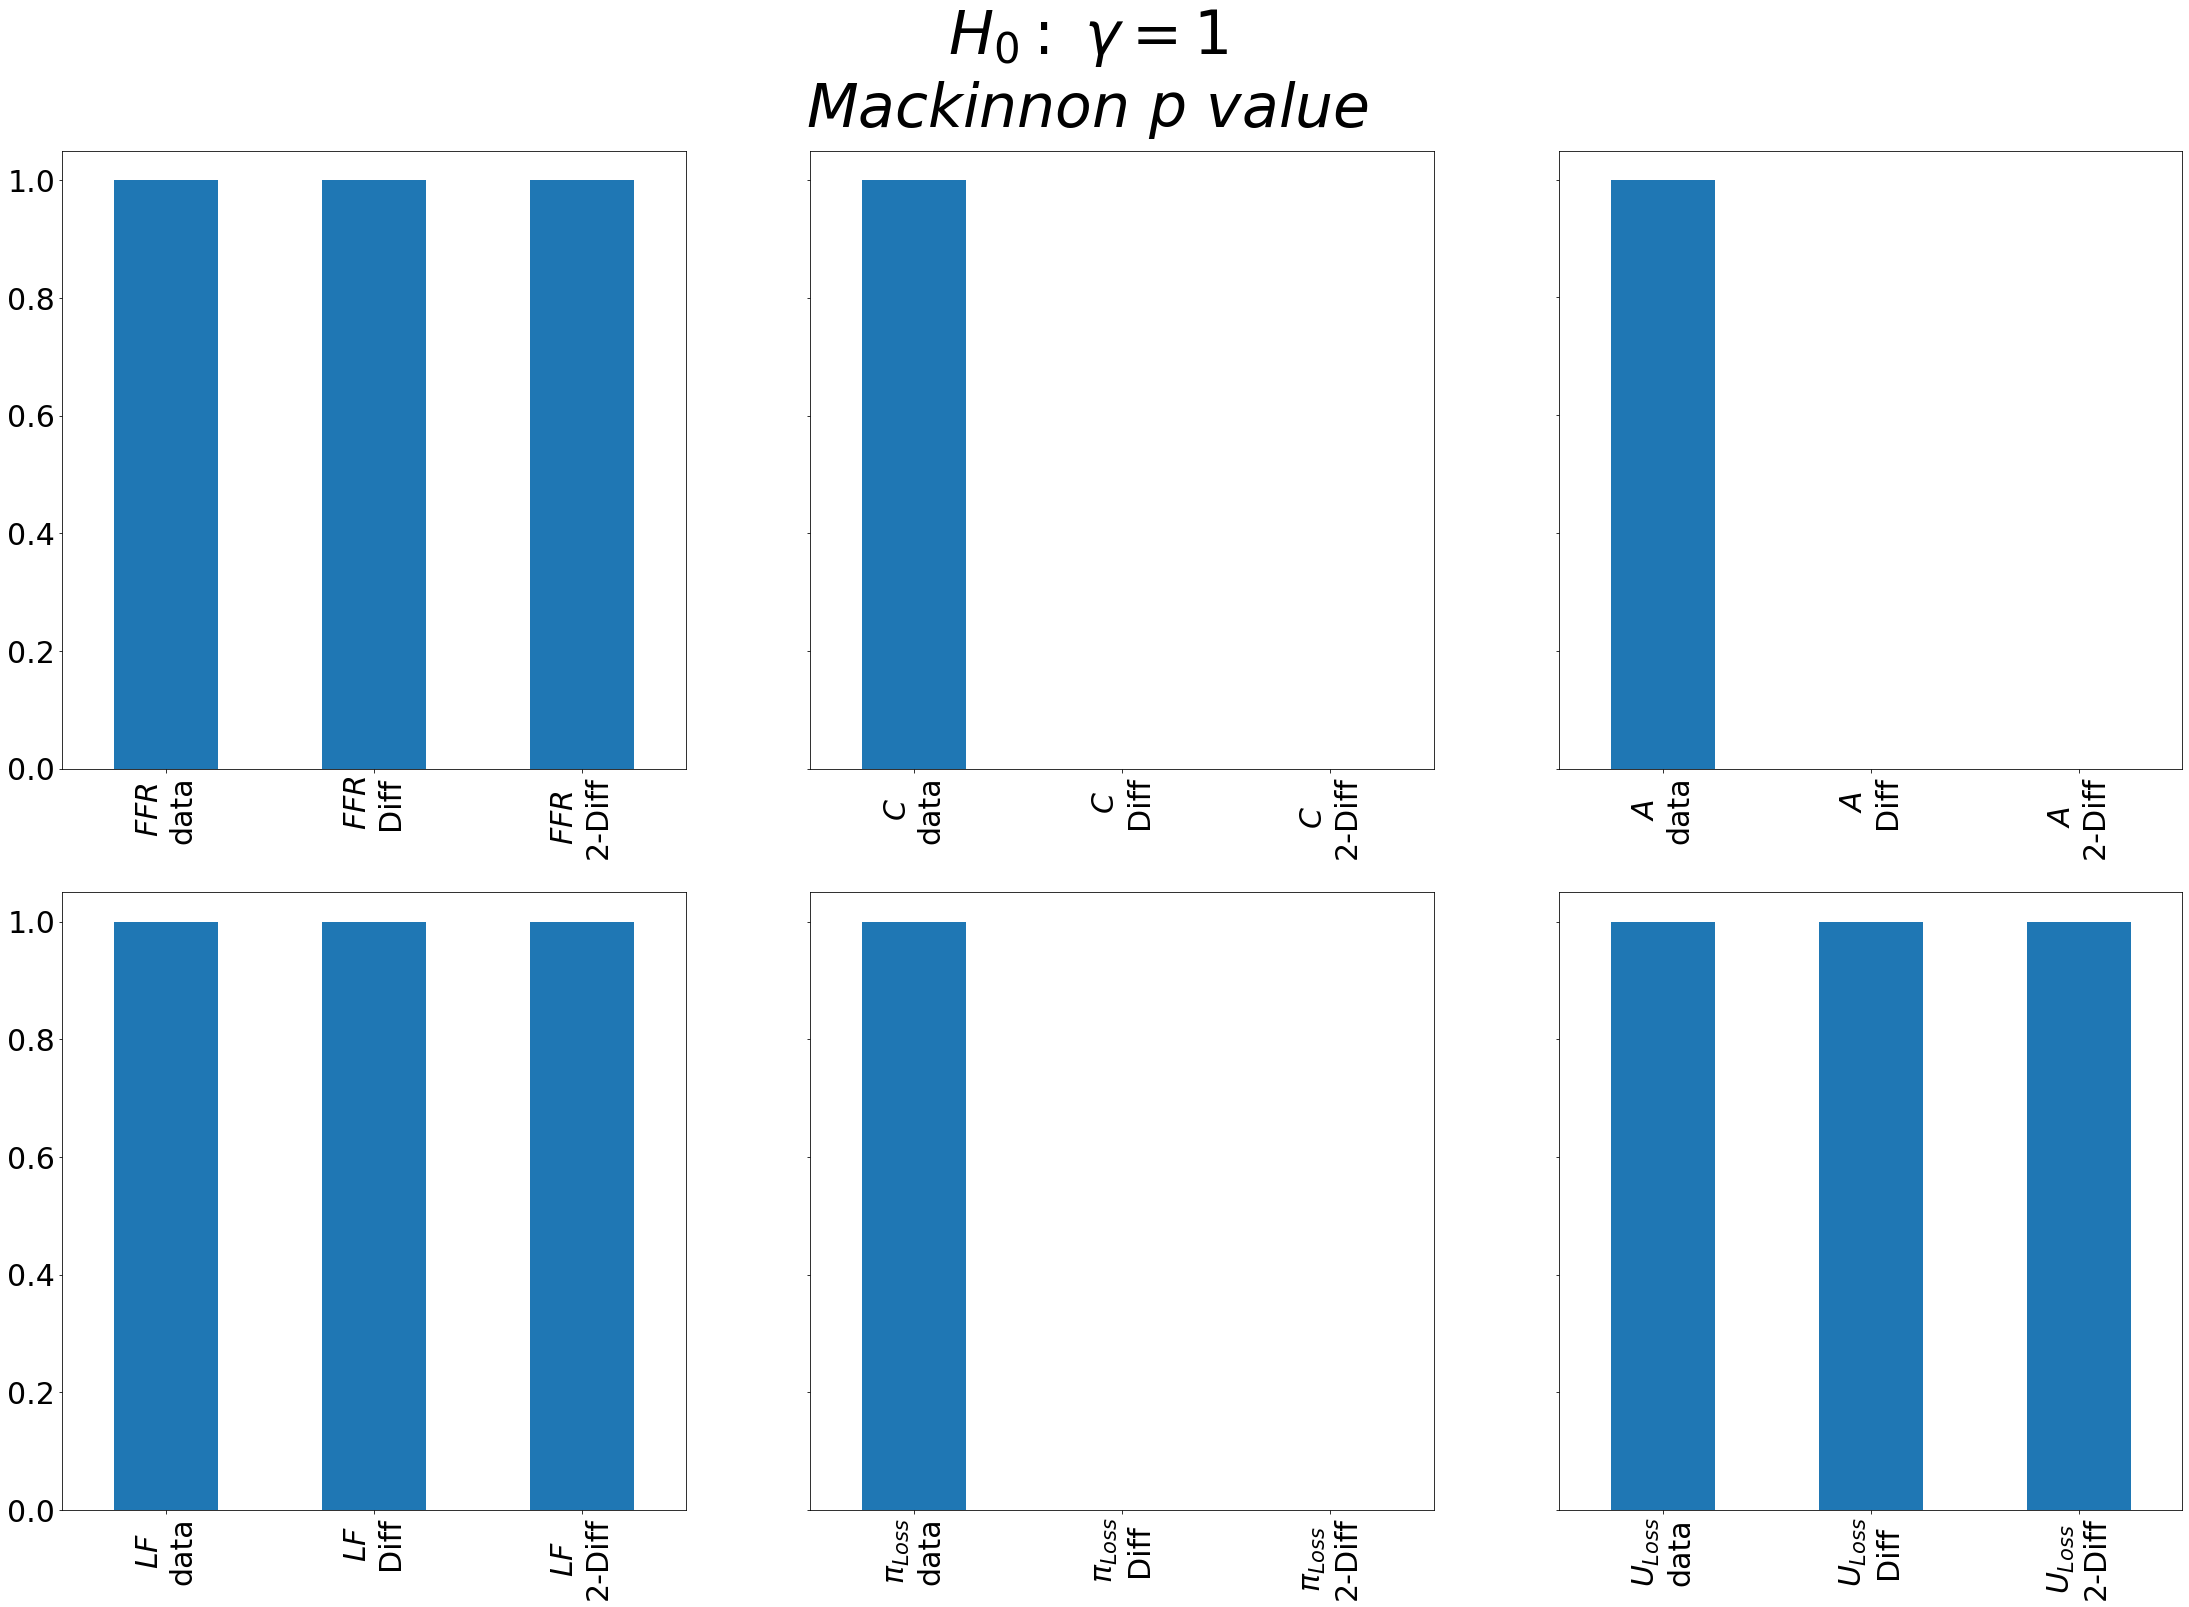

In [7]:
def dickey_fuller(data, 
                  key, 
                  lags = 1, 
                  annual_lags = True, 
                  time_trend = False, 
                  constant = True):
    lag_length = lags * year if annual_lags else lags
    test_data = data.copy()
    lag_freq = year if annual_lags else 1 
    test_data[key + " Diff"] = test_data[key].diff(lag_freq)
    lag_var = key + " Lag"
    test_data[lag_var] = test_data[key].shift(lag_freq)
    test_data[key + " Lag Diff"] = test_data[key].diff(lag_freq).shift(lag_freq)
    test_data.dropna(inplace = True)
    y = test_data[[key]]# + " Diff"]]
    X = test_data[[lag_var, key + " Lag Diff"]]
    regression = ""
    if constant:
        X["Constant"] = 1
        regression = "c"
    if time_trend:
        X["Time"] = np.arange(len(test_data[key]))
        regression = regression + "t"
    
    if not constant and not time_trend:
        regression = "nc"
    results = sm.OLS(y, X).fit()
    t = (results.params[0]) / results.cov_params().loc[lag_var, lag_var]
#     pvalue = results.pvalues[0]
    pvalue = mackinnonp(t, regression=regression, N=1, lags = lags)
    critvalues = mackinnoncrit(N=1, regression=regression, nobs=results.nobs)
    critvalues = {"1%" : critvalues[0], "5%" : critvalues[1],
                  "10%" : critvalues[2]}   
    print(key, pvalue)
    return [pvalue]

diffs = ["data", "Diff", "Diff-in-Diff"]
# diffs = [" Diff", " Diff-in-Diff"]
rename_dct = {"Effective":"$FFR$",
              "Circulation":"$C$",
             "Assets":"$A$",
              "Function":"$LF$",
             "Inflation Loss Sq":"$\pi_{Loss}$",
             "Unemployment Loss Sq":"$U_{Loss}$"}
adf_dct = {}
for key in rename_dct.values():
    adf_dct[key] = {}
for diff in data.keys():
    # test all variables, include loss fucntion components
    plot_vars_dct = {"ADF": [
        "Effective Federal Funds Rate (%)",
        "Currency in Circulation",
        "Total Assets",
        "Loss Function",
        "Unemployment Loss Sq" ,
        "Inflation Loss Sq"]}
    adf_data = data[diff][plot_vars_dct["ADF"]]#.loc["2008-10-31":"2020-02-29"]
    for key in adf_data:
        for rename_key in rename_dct:
            if rename_key in key:
                dif = diff if "Diff" in key else""
                lag = " Lag" if "Lag" in key else ""
                adf_data.rename(columns={key:rename_dct[rename_key]+dif + lag},
                                inplace = True)
    adf_data.dropna().to_csv("DAGData"+diff+".csv")
    # regression = "nc" generating error. Cannot find documentation for error, 
    # likely since mackinnonp is a submethod of ADF rather than a standalone
    # method
    constant = True
    time = False
#     if diff == "data":
#         time = False
#         constant = True

#     if diff == "Diff":
#         time = False
#         constant = True
#     if diff == "Diff-in-Diff":
#         time = False
#         constant = False
    for key in adf_data:
        adf_dct[key][diff] = dickey_fuller(adf_data.dropna().loc[:"2020-02-29"], 
                  key,
                  lags = 1,
                  annual_lags = True, 
                  time_trend = time, 
                  constant = constant) 
        


new_keys = list(rename_dct.values())
width = 2
length = 3
fig, ax = plt.subplots(width,
                       length, 
                       figsize = (38,25))
i = 0
j = 0
for key in new_keys:
    adf_df = pd.DataFrame(adf_dct[key])[diffs]
#     adf_df.plot.bar(legend = False)
    adf_df.T.plot.bar(ax = ax[j][i],legend = False)
    xtick_labels = ax[j][i].get_xticks()
    ax[j][i].set_xticklabels([key + "\n" + diff.replace("Diff-in-Diff","2-Diff") for diff in diffs],
                            fontsize = 30)
    
    if i == 0:
        ax[j][i].set_yticklabels([round(y,2) for y in ax[j][i].get_yticks()],
                            fontsize = 30)
    else:
        ax[j][i].set_yticklabels(["" for y in ax[j][i].get_yticks()])

    i+=1

    if i == length:
        i = 0
        j += 1
#     if i == 2 and j == 1:
#         ax[j][i].set_axis_off()
    fig.suptitle("$H_0:$ $\gamma = 1$\n$Mackinnon$ $p$ $value$", y = .96, fontsize = 60)
        

In [8]:
adf_dct

{'$FFR$': {'data': [1.0], 'Diff': [1.0], 'Diff-in-Diff': [1.0]},
 '$C$': {'data': [1.0], 'Diff': [0.0], 'Diff-in-Diff': [0.0]},
 '$A$': {'data': [0.9988709445681236], 'Diff': [0.0], 'Diff-in-Diff': [0.0]},
 '$LF$': {'data': [1.0], 'Diff': [1.0], 'Diff-in-Diff': [1.0]},
 '$\\pi_{Loss}$': {'data': [1.0], 'Diff': [0.0], 'Diff-in-Diff': [0.0]},
 '$U_{Loss}$': {'data': [1.0], 'Diff': [1.0], 'Diff-in-Diff': [1.0]}}

In [9]:
adf_data.dropna()

,$FFR$,$C$,$A$,$LF$,$U_{Loss}$,$\pi_{Loss}$
DATE,,,,,,
2004-12-31,1.171935,-0.006413,0.016904,0.646622,-0.63,0.016622
2005-01-31,1.282258,0.000492,0.012750,0.813303,-0.80,0.013303
2005-02-28,1.494544,0.002776,0.016558,0.412474,-0.40,0.012474
2005-03-31,1.627419,0.008396,0.017146,1.215318,-1.20,0.015318
2005-04-30,1.781000,0.007823,0.019289,0.723721,-0.72,0.003721
...,...,...,...,...,...,...
2022-02-28,0.004286,-0.095582,-0.416155,3.525012,-3.38,0.145012
2022-03-31,0.131290,-0.081883,-0.348846,3.182513,-3.06,0.122513
2022-04-30,0.261000,-0.080518,-0.070190,3.129021,-3.06,0.069021


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

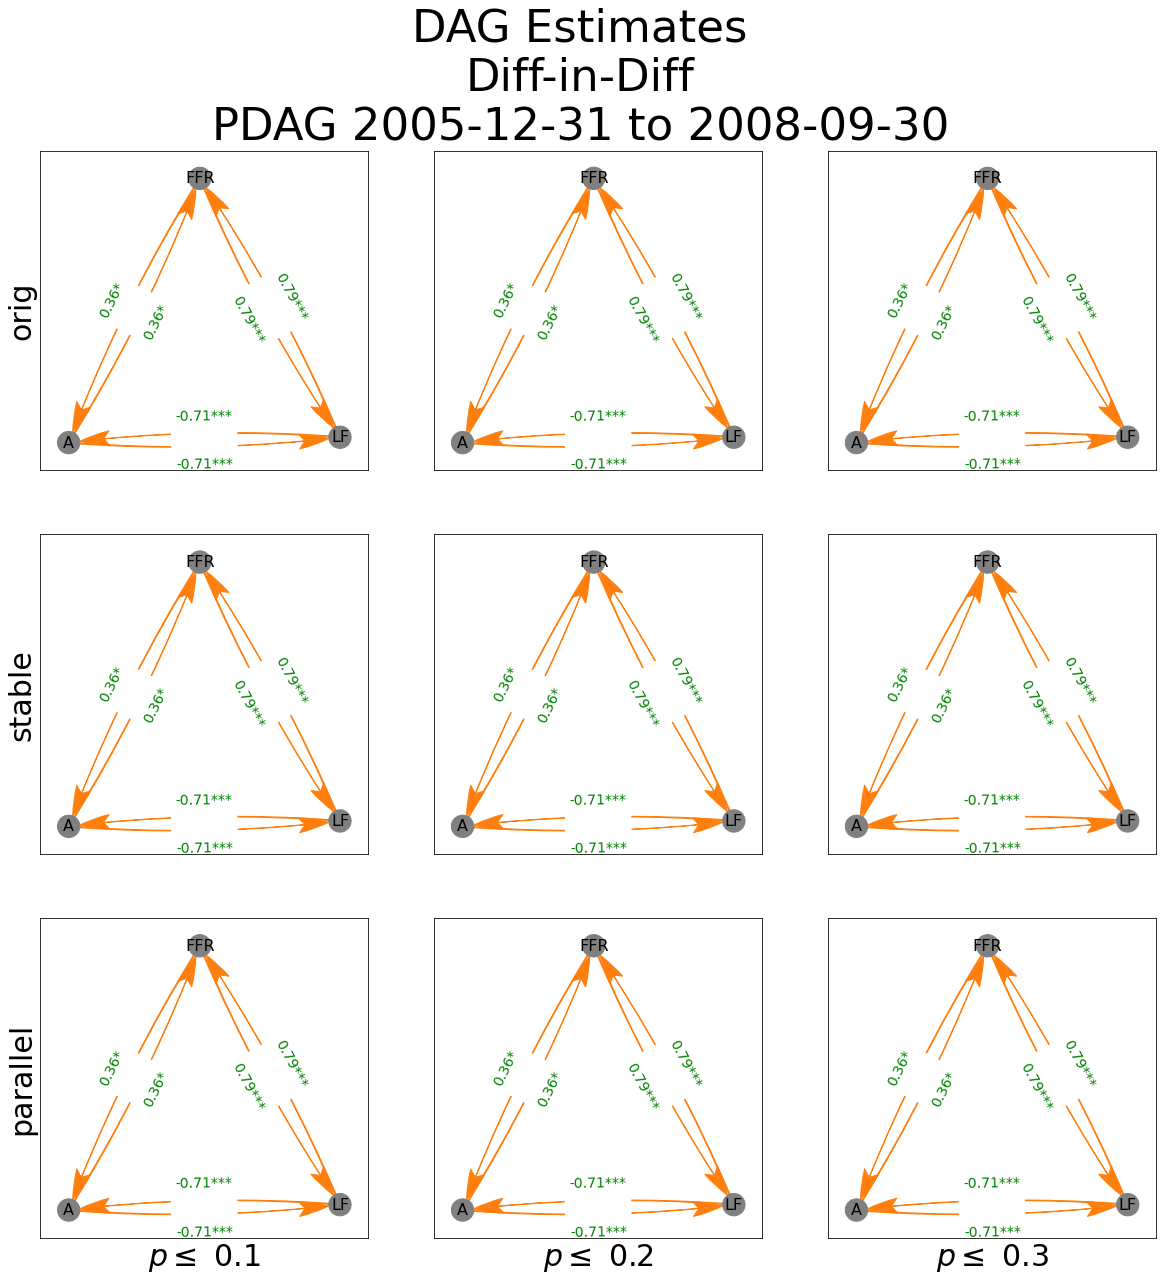

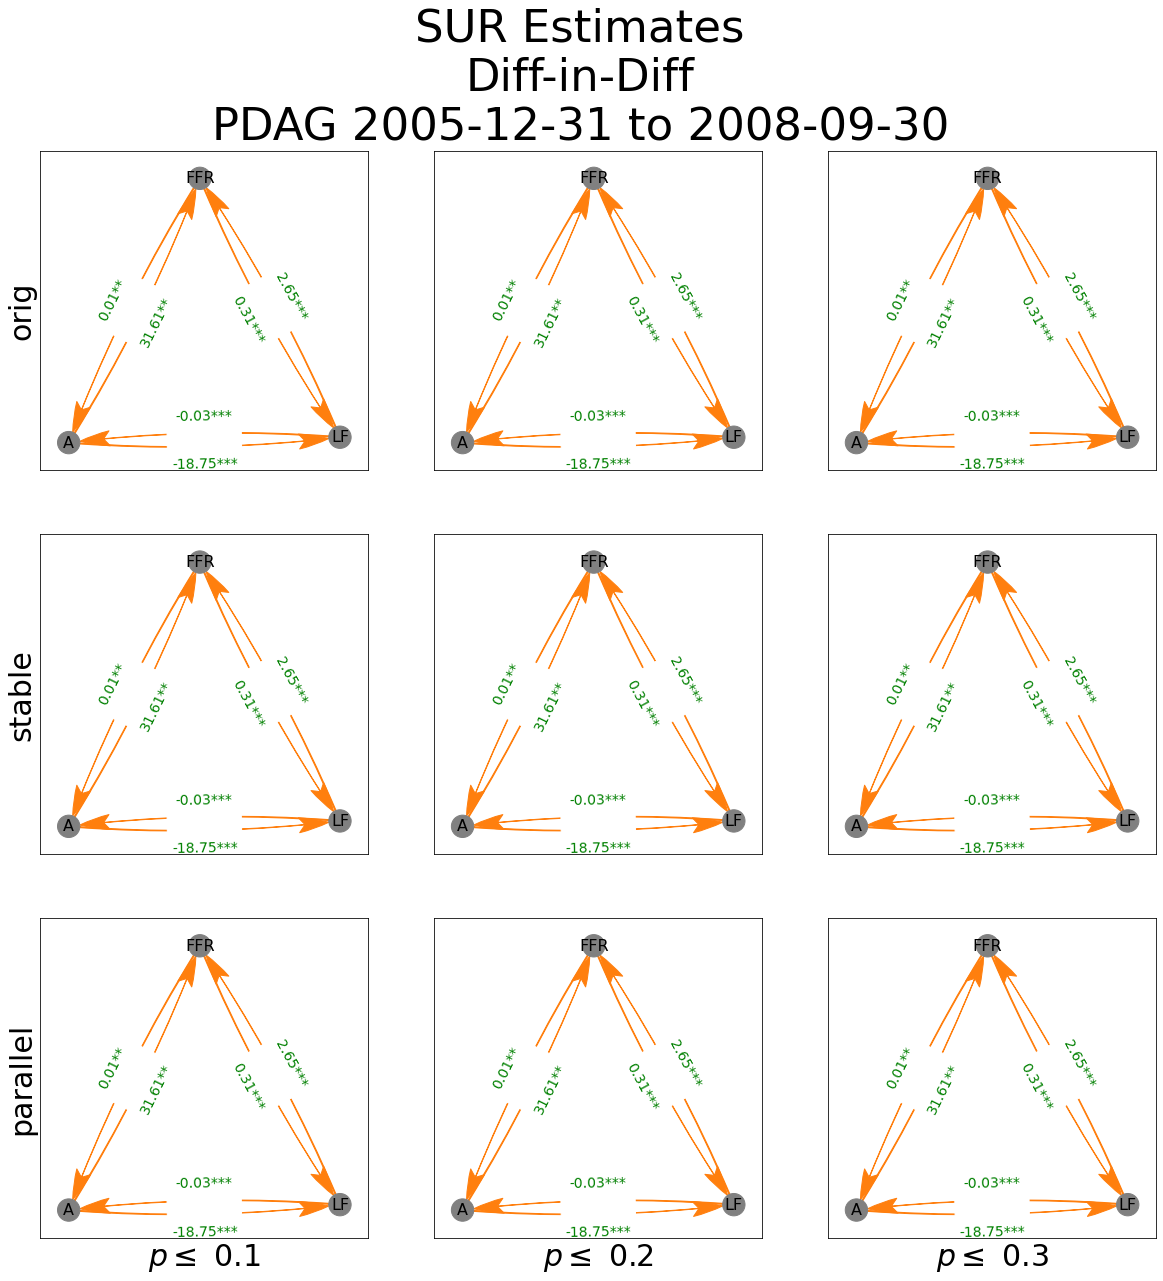

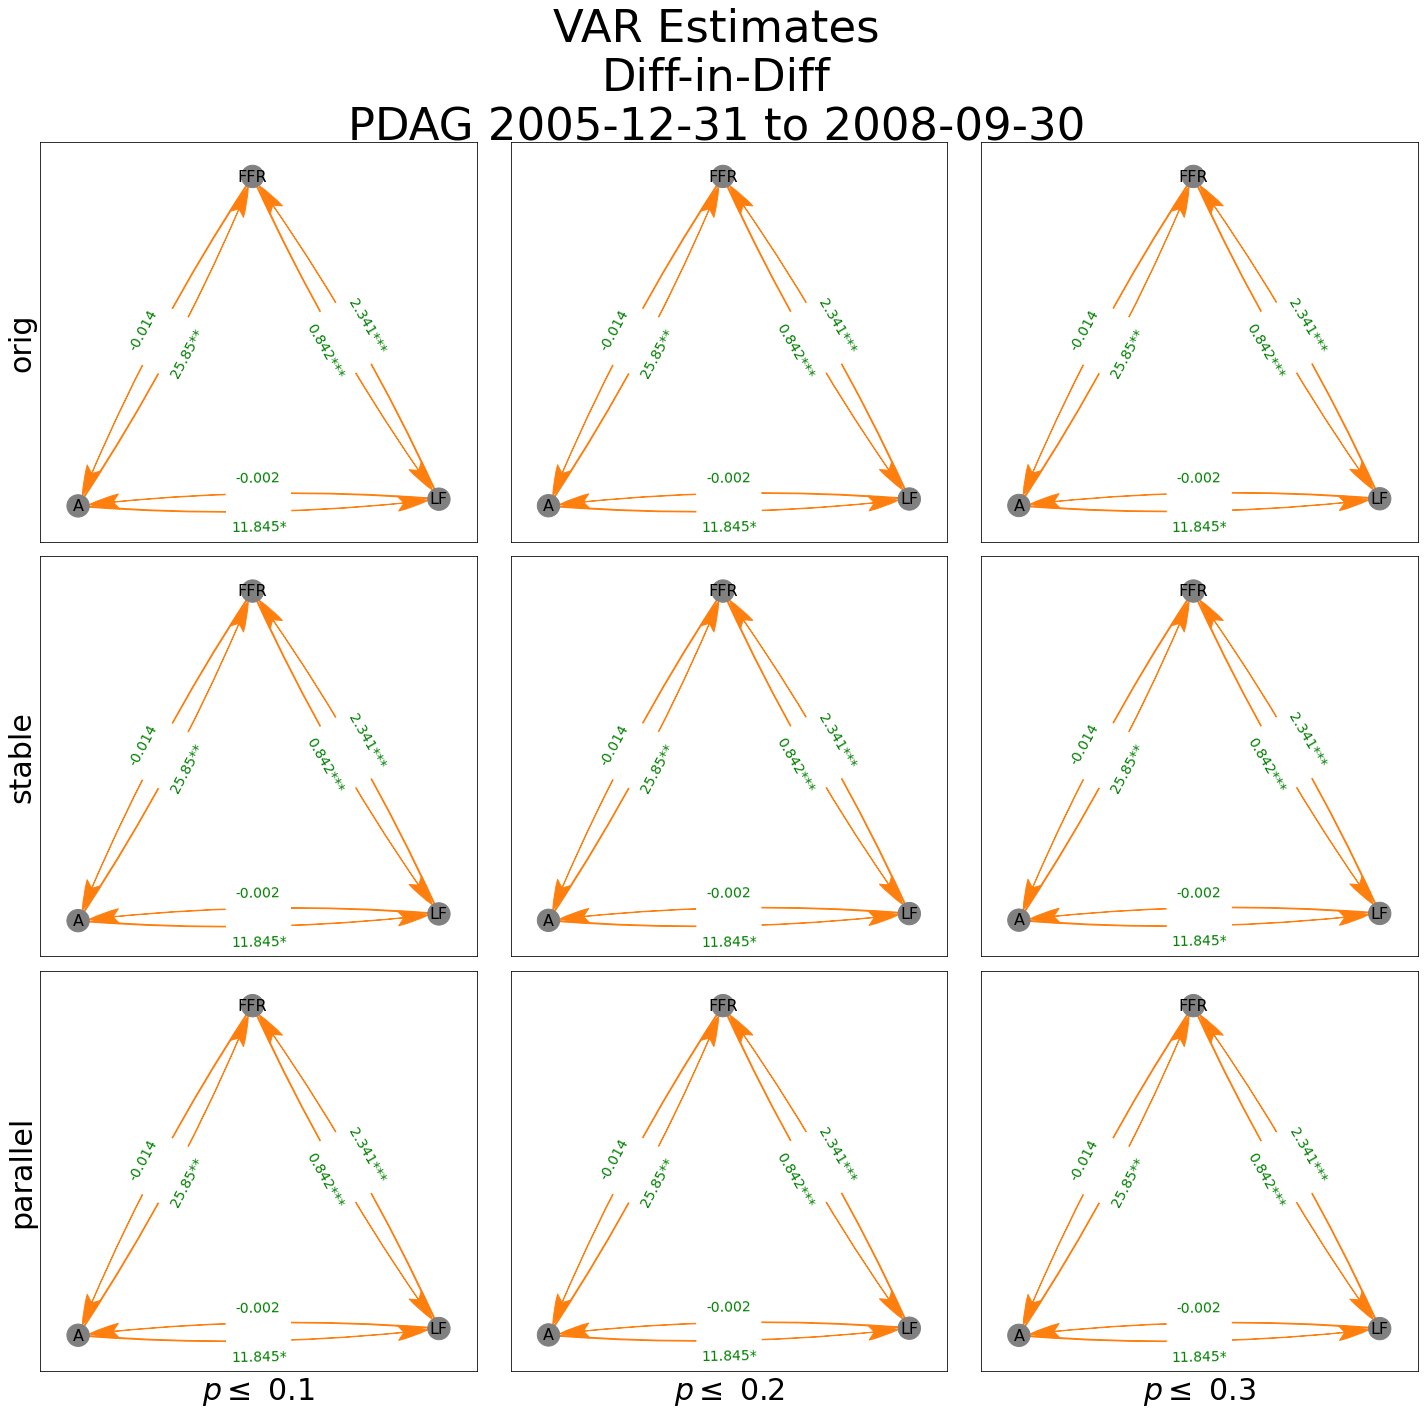

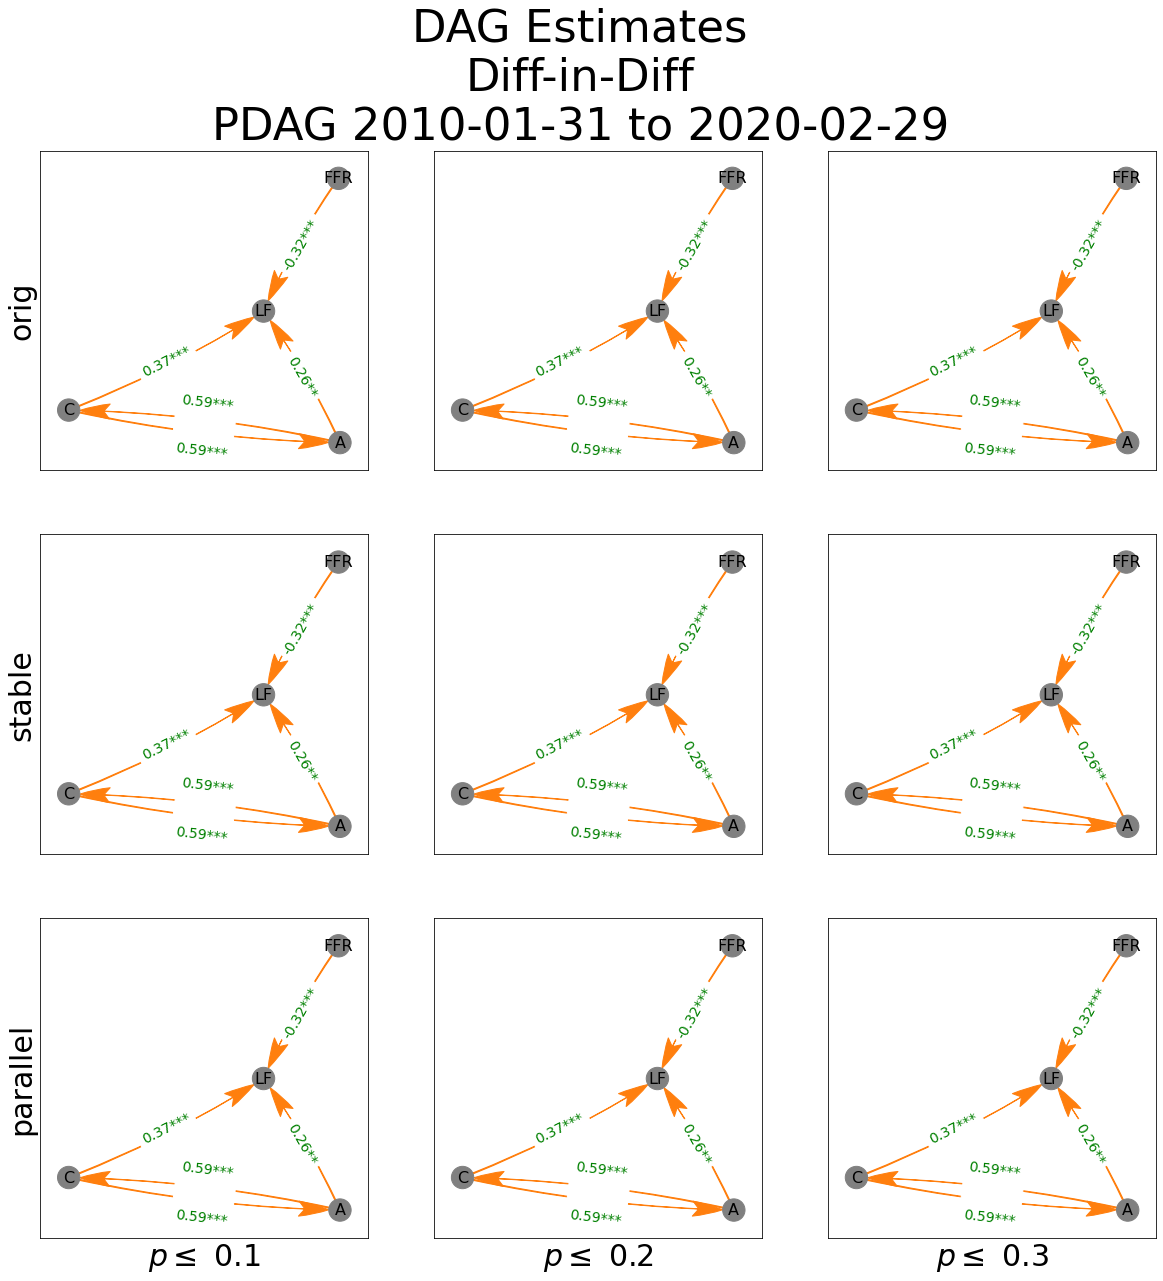

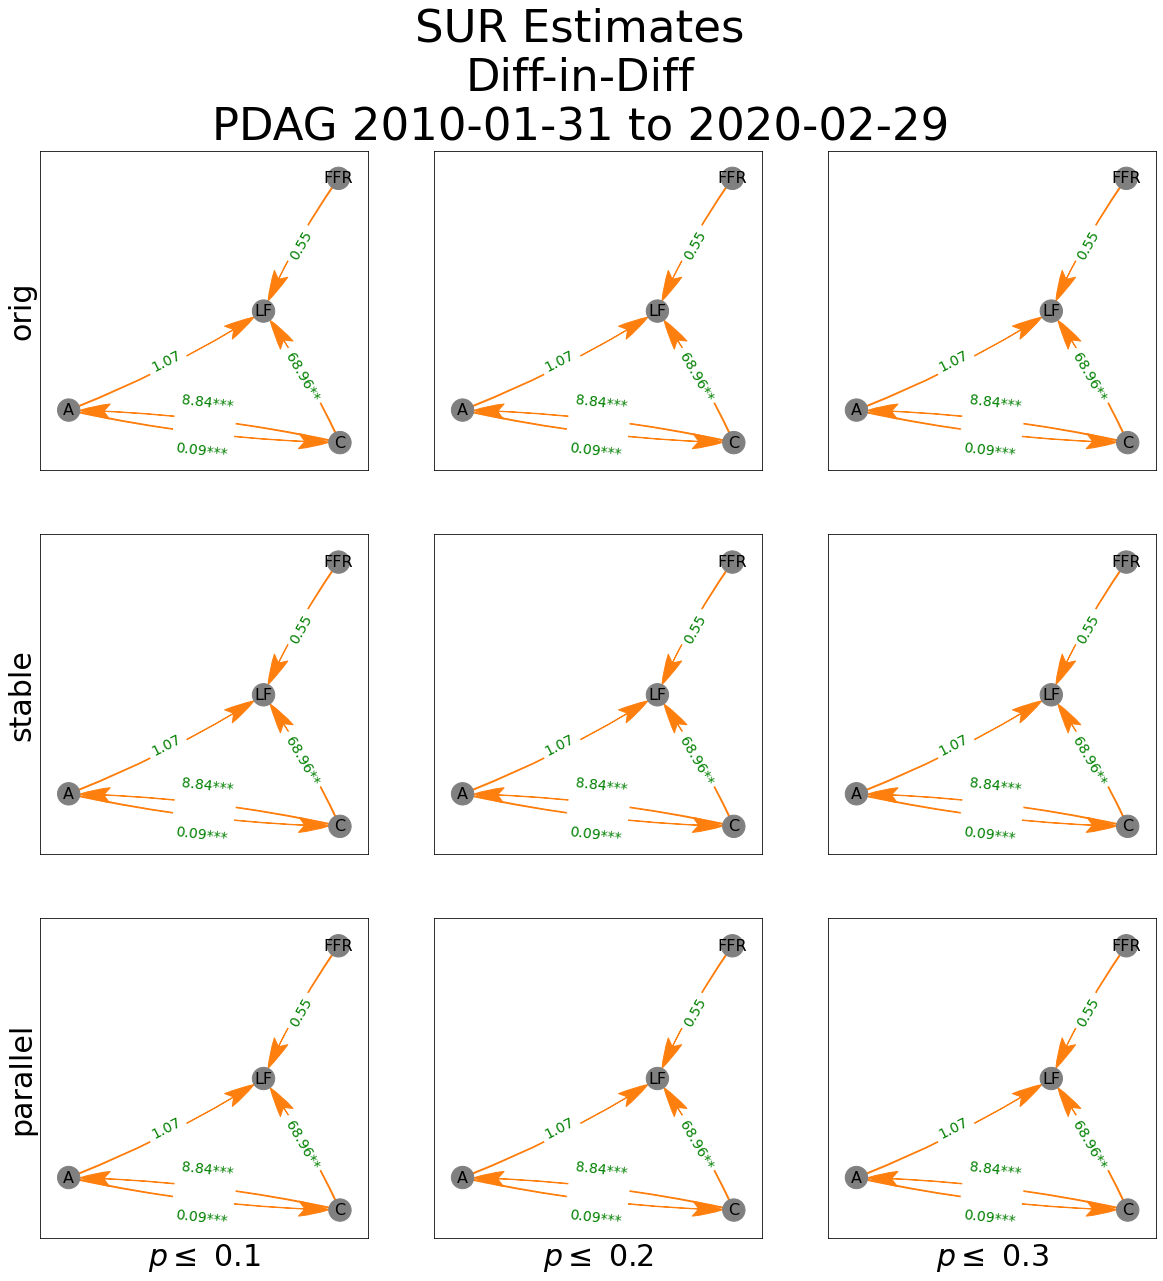

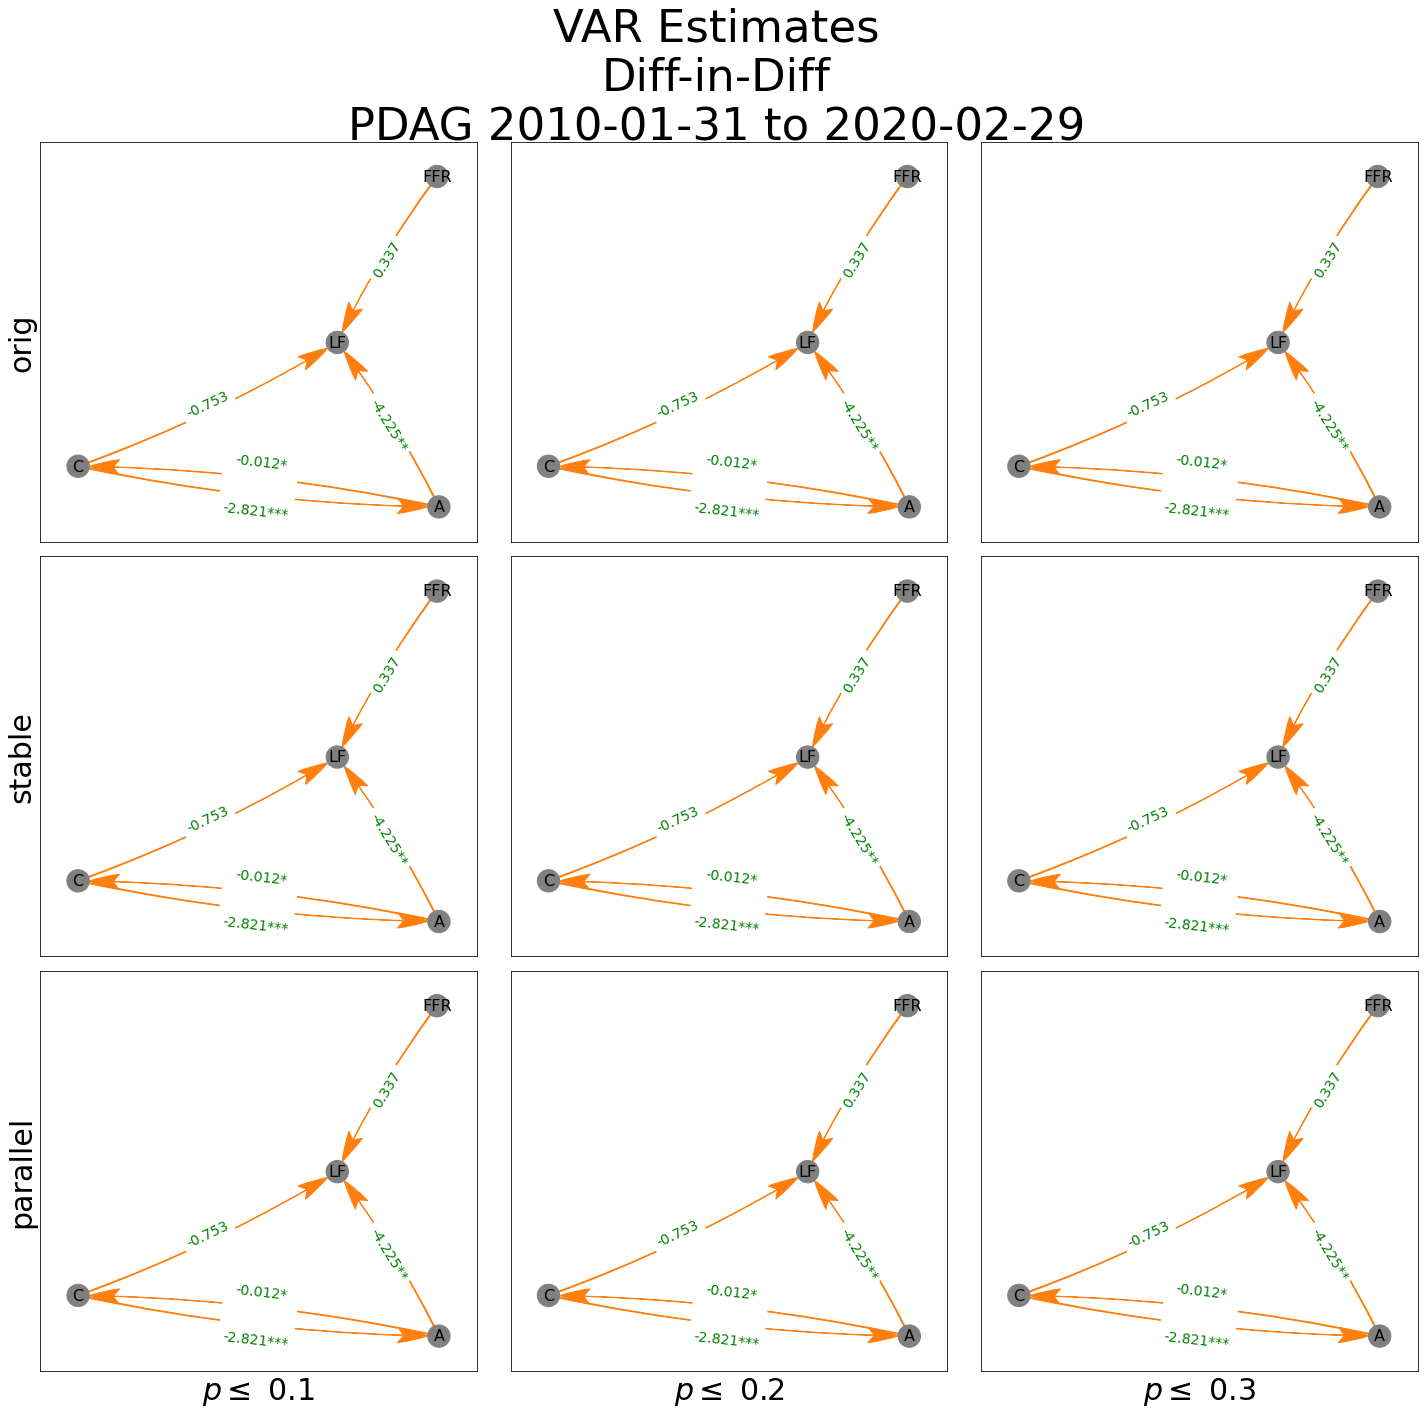

In [10]:
from datlib.DAG import *
from collections import OrderedDict
from linearmodels.system import SUR
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats


# plt.rcParams.update({"font.size":20})
# pd.to_datetime(data['Date'])
# data.set_index("Date")
diff = "Diff-in-Diff"

rename_dct = {"Effective":"FFR",
             "Circulation / Total":"C/A",
              "Circulation":"C",
             "Assets":"A",
              "Function":"LF",
             "Inflation":"$\pi$",
             "Unemployment":"U"}
sig_vals = [.05, .01, .001]


def add_lags(data, lags=12 / year):
    for key in data:
        for i in range(1, lags + 1):
            new_key = key +" Lag" * i
            data[new_key] = var_data[key].shift(year * i)

def rename_vars(rename_data, rename_dct):
    for key in rename_data:
        for rename_key in rename_dct:
            if rename_key in key:
                rename_data.rename(columns={key:rename_dct[rename_key]}, inplace = True)                


                
# only estimate twice differenced data since a some variables fail to reject the null
# diffs = ["", " Diff", " Diff-in-Diff"]
pp = PdfPages("MacroDAGsForPaper.pdf")
reg_dict = {}
lags = int(round(12 / year,0))

## Use return_type = "pdag" to allow for endogeneity
##  "dag" disallows this sort ambiguity
reg_dict[diff] = {}
# only test the aggregated data, since the hypothesis is that:
    # 1) currency and total assets are indicate relative provision of liquidity
    # 2) loss function variables are targeted together

plot_vars =  ["Effective Federal Funds Rate (%)",
                                    "Currency in Circulation",
                                    "Total Assets",
                                    "Loss Function"]
sig = sigs = [0.1, 0.2, 0.3]
variants = ["orig", "stable", "parallel"]
ci_test = "pearsonr"


# for plot_vars in plot_vars_dct:
i = ""
reg_dict[diff][i] = {}
df = data[diff]
var_data = df[plot_vars]
rename_vars(var_data, rename_dct)
add_lags(var_data, lags)
var_data.dropna(inplace=True)
start_end_list = [(str(var_data.index[0])[:10],"2008-09-30"),
                  ("2010-01-31", "2020-02-29")]#,
#                       ("2008-10-31", "2020-02-29"),
#                       (str(var_data.index[0])[:10],"2020-02-29")]        

# slice dfs by date range, house in dfs {}
dfs = {}
for start,end in start_end_list:
    dfs[start +" to " + end] =  var_data.loc[start:end].copy() 

# use dates (key) to track dates for which hypotheses are tested
for dates, select_df in dfs.items():
    for return_type in ["pdag"]:
        edges = {}
        dag_df = {}
        fig, ax = plt.subplots(3,3,figsize = (20,20))
        fig.suptitle("DAG Estimates\n"+diff.replace(" ", "") + "\n" + return_type.upper() +" " + dates,
                    fontsize = 45)

        fig_sur, ax_sur = plt.subplots(3,3,figsize = (20,20))
        fig_sur.suptitle("SUR Estimates\n"+diff.replace(" ", "") + "\n" + return_type.upper() +" " + dates,
                    fontsize = 45)
        fig_var, ax_var = plt.subplots(3,3,figsize = (20,20))
        fig_var.suptitle("VAR Estimates\n"+diff.replace(" ", "") + "\n" + return_type.upper() +" " + dates,
                    fontsize = 45)

        for x in range(len(sigs)):
            sig = sigs[x]
            edges[sig] = {}
            dag_df[sig] = {}
            for y in range(len(variants)):
                variant = variants[y]
                a = ax[y][x]

                constant = False if diff == " Diff-in-Diff" else True
                keys = [k for k in select_df if "Lag" not in k]
                dag_df[sig][variant] = select_df[keys].dropna()
                # construct dag, save directed edges
                edges[sig][variant] = DAG(dag_df[sig][variant], variant, ci_test, sig, return_type)
                # construct graphs with PC labels
                graph_DAG(edges[sig][variant], 
                          dag_df[sig][variant], 
                          title = "",
                          fig = fig,
                          ax = a)
                if x == 0:
                    a.set_ylabel(variant, fontsize = 30)
                if y == len(variants) - 1:
                    a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 30)
                a = ax_sur[y][x]
#                     # identify sink nodes in directed dag edges, use info to detect structure of regressions
#                     #  additional graphs with marginal effects from SUR and VAR are constructed
                sink_source = identify_sink_nodes(edges[sig][variant])
                filename = i + " " + diff + "DAGOLS " + dates + " " + variant + str(sig) 
                DAG_OLS(dag_df[sig][variant], sink_source, filename, a, diff, dates,constant = constant, return_type = return_type)    
                if x == 0:
                    a.set_ylabel(variant, fontsize = 30)
                if y == len(variants) - 1:
                    a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 30)

                a = ax_var[y][x]

#                     filename = i + " " + diff + "DAGVAR " + dates 
                DAG_VAR(select_df.dropna(), sink_source, filename, a, diff, dates, sig_vals,constant = constant, return_type = return_type)
                if x == 0:
                    a.set_ylabel(variant, fontsize = 30)
                if y == len(variants) - 1:
                    a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 30)

pp.close()